In [4]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ISLP import load_data, confusion_table
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.metrics import RocCurveDisplay
roc_curve_est = RocCurveDisplay.from_estimator 
roc_curve_pred = RocCurveDisplay.from_predictions
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR,
      RandomForestClassifier as RC, 
      GradientBoostingClassifier as GBC)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold as SKF, GridSearchCV  
from functools import partial
from sklearn.model_selection import \
     (cross_validate,
      ShuffleSplit)
from sklearn.decomposition import PCA
from sklearn.base import clone
from ISLP.models import sklearn_sm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import make_scorer, recall_score
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import statsmodels as sm
import statsmodels.api as sm
from ISLP.models import (ModelSpec as MS,
                         summarize)
import math 
from sklearn.feature_selection import SelectKBest, f_classif


In [5]:
data = pd.read_csv("Cancer_Data.csv").drop(columns={"Unnamed: 32"})
X = data.drop(columns={"diagnosis"})
y = data["diagnosis"].map({"M": 1, "B": 0}).astype(int)
X = X.drop(columns={"id"})

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=314,
                                                    test_size=0.20,
                                                    shuffle=True)

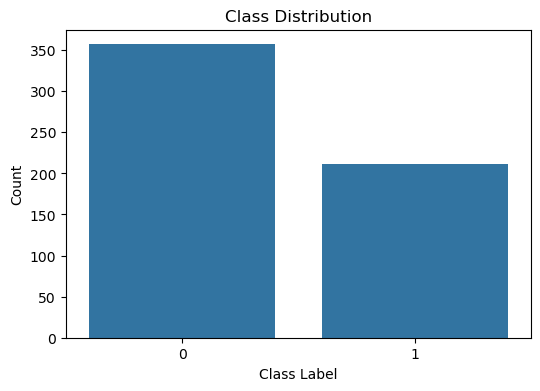

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# If y is a pandas Series
class_counts = y.value_counts().sort_index()

# Bar plot
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

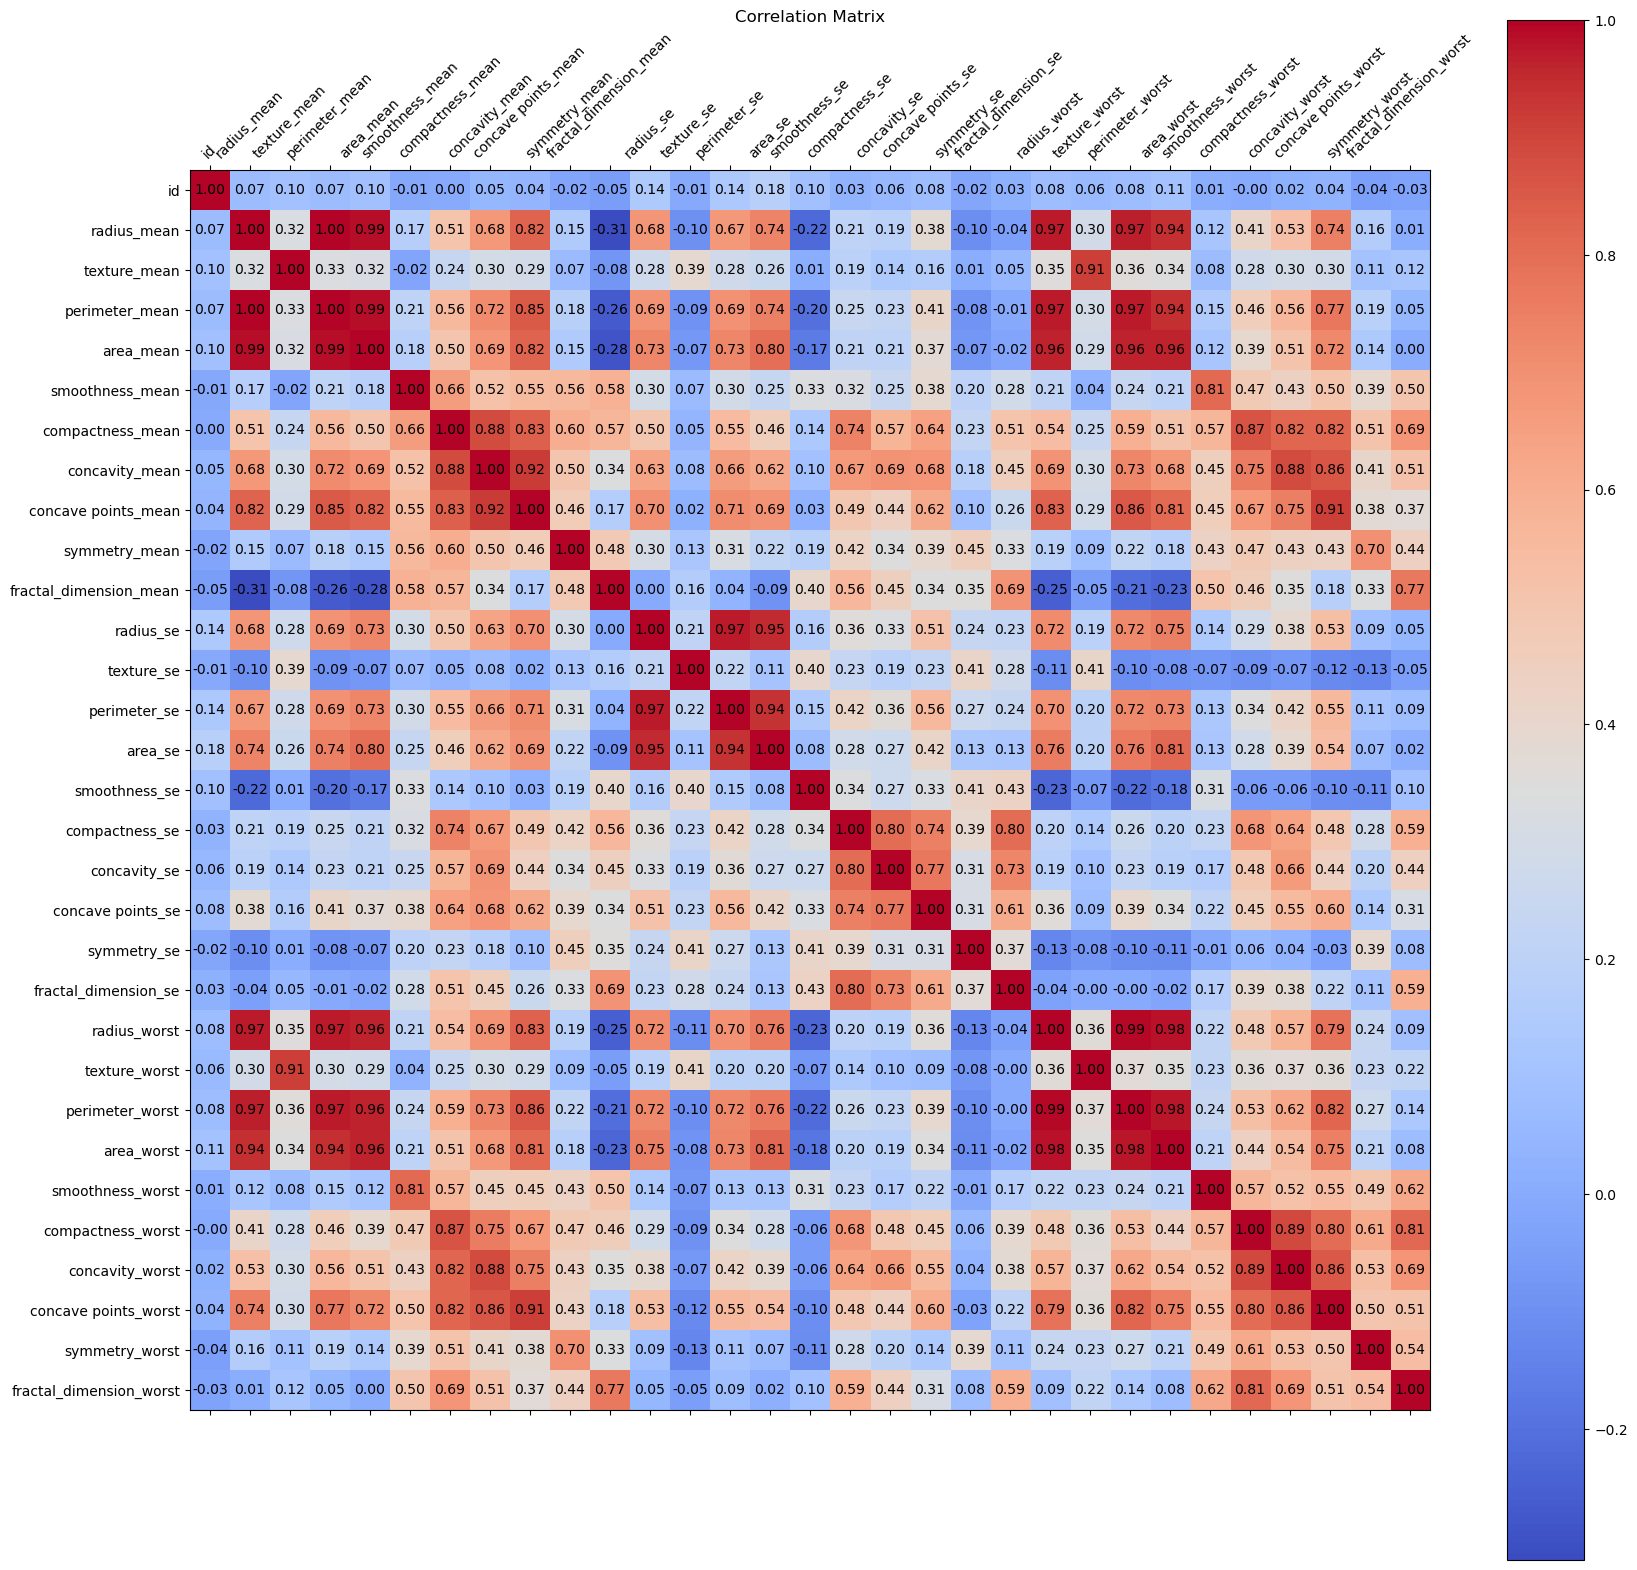

In [7]:
data2 = data.drop(columns={"diagnosis"})
corr_matrix = data2.corr()
fig, ax = plt.subplots(figsize=(20, 20))
cax = ax.matshow(corr_matrix, cmap='coolwarm')

plt.colorbar(cax)

# Set axis labels
ax.set_xticks(range(len(data2.columns)))
ax.set_yticks(range(len(data2.columns)))

ax.set_xticklabels(data2.columns, rotation=45)
ax.set_yticklabels(data2.columns)

# Add numerical values
for (i, j), val in np.ndenumerate(corr_matrix):
    ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="black")

plt.title("Correlation Matrix")
plt.show()

# Logistic Regression

In [137]:
kf = KFold(n_splits=5, shuffle=True, random_state=314)
loadings_lst= []
train_acc = []
test_acc = []

# perform PCA with 5-fold cross-validation
for train_index, test_index in kf.split(X_train, y_train):
    X_traincv, X_testcv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_traincv, y_testcv = y_train.iloc[train_index], y_train.iloc[test_index]

    pca = PCA(n_components=3)  
    X_train_pca = pca.fit_transform(X_traincv)
    X_test_pca = pca.transform(X_testcv)

    loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],  # Use actual PCA component count
    index=X_train.columns  # Keep original feature names
)

    loadings_lst.append(loadings)

    # train a logistic regression model on the PCA components
    logit_model = LogisticRegression(max_iter=1000, random_state=314)
    logit_model.fit(X_train_pca, y_traincv)

    # Get train accuracy
    y_pred_proba = logit_model.predict_proba(X_train_pca)[:, 1]
    threshold = 0.4
    y_pred_adjusted = (y_pred_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_traincv, y_pred_adjusted)
    train_acc.append(accuracy)

    # Get test accuracy
    logit_model.fit(X_test_pca, y_testcv)
    y_pred_proba_test = logit_model.predict_proba(X_test_pca)[:, 1]
    threshold = 0.4
    y_pred_adjusted_test = (y_pred_proba_test >= threshold).astype(int)
    accuracy_test = accuracy_score(y_testcv, y_pred_adjusted_test)
    test_acc.append(accuracy_test)


print("Avg Train Accuracy", pd.DataFrame(train_acc).mean())
print("Avg Test Accuracy", pd.DataFrame(test_acc).mean())

Avg Train Accuracy 0    0.918681
dtype: float64
Avg Test Accuracy 0    0.923077
dtype: float64


In [138]:
kf = KFold(n_splits=5, shuffle=True, random_state=314)
loadings_lst= []
train_acc = []
test_acc = []

# perform PCA with 5-fold cross-validation
for train_index, test_index in kf.split(X_train, y_train):
    X_traincv, X_testcv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_traincv, y_testcv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Standardize the data
    CV_scaler = StandardScaler()
    X_traincv = pd.DataFrame(CV_scaler.fit_transform(X_traincv), index=X_traincv.index, columns=X_traincv.columns)
    X_testcv = pd.DataFrame(CV_scaler.transform(X_testcv), index=X_testcv.index, columns=X_testcv.columns)

    pca = PCA(n_components=3)  
    X_train_pca = pca.fit_transform(X_traincv)
    X_test_pca = pca.transform(X_testcv)

    loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],  # Use actual PCA component count
    index=X_train.columns  # Keep original feature names
)

    loadings_lst.append(loadings)

    # train a logistic regression model on the PCA components
    logit_model = LogisticRegression(max_iter=1000, random_state=314)
    logit_model.fit(X_train_pca, y_traincv)

    # Get train accuracy
    y_pred_proba = logit_model.predict_proba(X_train_pca)[:, 1]
    threshold = 0.4
    y_pred_adjusted = (y_pred_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_traincv, y_pred_adjusted)
    train_acc.append(accuracy)

    # Get test accuracy
    logit_model.fit(X_test_pca, y_testcv)
    y_pred_proba_test = logit_model.predict_proba(X_test_pca)[:, 1]
    threshold = 0.4
    y_pred_adjusted_test = (y_pred_proba_test >= threshold).astype(int)
    accuracy_test = accuracy_score(y_testcv, y_pred_adjusted_test)
    test_acc.append(accuracy_test)


print("Avg Train Accuracy", pd.DataFrame(train_acc).mean())
print("Avg Test Accuracy", pd.DataFrame(test_acc).mean())

Avg Train Accuracy 0    0.94011
dtype: float64
Avg Test Accuracy 0    0.942857
dtype: float64


In [139]:
mean_loadings = pd.concat(loadings_lst).groupby(level=0).mean()
loadings_abs = np.abs(mean_loadings)  # Take absolute values
top_features = loadings_abs.mean(axis=1).sort_values(ascending=False).head(5)  # Top 10 overall
top_features

fractal_dimension_worst    0.211155
fractal_dimension_se       0.200111
compactness_worst          0.198434
radius_se                  0.194578
area_se                    0.190225
dtype: float64

In [140]:
selected_features = top_features.index.tolist()
selected_features

['fractal_dimension_worst',
 'fractal_dimension_se',
 'compactness_worst',
 'radius_se',
 'area_se']

In [141]:
X_trainlog = X_train[selected_features]
X_testlog = X_test[selected_features]

print(X_trainlog.shape, X_testlog.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_trainlog)
X_trainlog = pd.DataFrame(X_train_scaled, columns=X_trainlog.columns, index=X_trainlog.index)
X_test_scaled = scaler.transform(X_testlog)
X_testlog = pd.DataFrame(X_test_scaled, columns=X_testlog.columns, index=X_testlog.index)

log_model = LogisticRegression(max_iter=3000, random_state=42)
log_model.fit(X_trainlog, y_train)

# train accuracy
y_probs = log_model.predict_proba(X_trainlog)[:, 1]  
threshold = 0.4

y_train_adjusted = (y_probs >= threshold).astype(int)  
print("Train Accuracy:", accuracy_score(y_train, y_train_adjusted))

y_probs = log_model.predict_proba(X_testlog)[:, 1] 
threshold = 0.4
y_pred_adjusted = (y_probs >= threshold).astype(int)  # Convert probabilities to binary label
print("Test Accuracy:", accuracy_score(y_test, y_pred_adjusted))

log_conf = confusion_table(y_test, y_pred_adjusted)

(455, 5) (114, 5)
Train Accuracy: 0.9252747252747253
Test Accuracy: 0.956140350877193


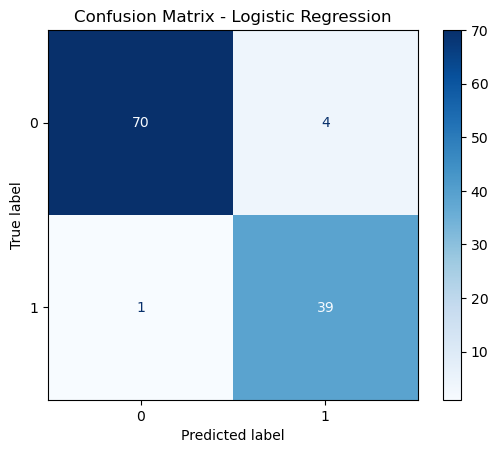

In [142]:
labels = ['Benign', 'Malignant'] if 'B' in y_test.values else None

disp_lr = ConfusionMatrixDisplay(confusion_matrix=np.array(log_conf), display_labels=labels)
disp_lr.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

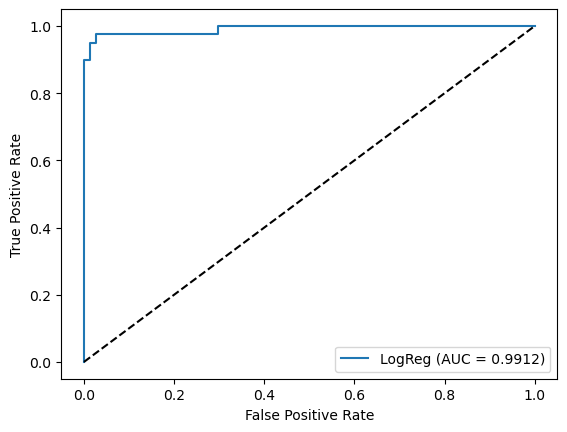

In [143]:
from sklearn.metrics import roc_curve, auc

# get the probability of the positive class
y_score = log_model.predict_proba(X_testlog)[:, 1]  

fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# then plot it
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label=f"LogReg (AUC = {roc_auc:.4f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# KNN

In [8]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score
import numpy as np

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=314)

feature_range = [5, 10, 15]
k_range = range(1, 16)

best_score = 0
best_k = None
best_f = None
best_feature_mask = None

for num_features in feature_range:
    for k_val in k_range:
        fold_scores = []

        for train_idx, val_idx in kf.split(X_train, y_train):
            X_traincv = X_train.iloc[train_idx]
            X_valcv = X_train.iloc[val_idx]
            y_traincv = y_train.iloc[train_idx]
            y_valcv = y_train.iloc[val_idx]

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_traincv)
            X_val_scaled = scaler.transform(X_valcv)

            selector = SelectKBest(score_func=f_classif, k=num_features)
            X_train_selected = selector.fit_transform(X_train_scaled, y_traincv)
            X_val_selected = selector.transform(X_val_scaled)

            knn = KNN(n_neighbors=k_val)
            knn.fit(X_train_selected, y_traincv)
            y_pred_proba = knn.predict_proba(X_val_selected)[:, 1]
            threshold = 0.4
            y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

            score = accuracy_score(y_valcv, y_pred_adjusted)
            fold_scores.append(score)

        avg_score = np.mean(fold_scores)

        if avg_score > best_score:
            best_score = avg_score
            best_k = k_val
            best_f = num_features
            best_feature_mask = selector.get_support()  # Save the best feature mask

# Report best results
print(f"Best cross-validation score: {best_score:.4f}")
print(f"Best number of neighbors: {best_k}")
print(f"Best number of features: {best_f}")

# Show selected feature names
selected_features = X_train.columns[best_feature_mask]
print("Selected Features:")
for feat in selected_features:
    print("-", feat)

Best cross-validation score: 0.9495
Best number of neighbors: 6
Best number of features: 5
Selected Features:
- perimeter_mean
- concave points_mean
- radius_worst
- perimeter_worst
- concave points_worst


In [ ]:
X_train_Knn = X_train[selected_features]
X_test_Knn = X_test[selected_features]

# Standardize 
scaler = StandardScaler()
X_train_Knn_scaled = scaler.fit_transform(X_train_Knn)
X_test_Knn_scaled = scaler.transform(X_test_Knn)
#CHANGED TO 6 FROM ABOVE
knn = KNN(n_neighbors=6) # 9 was determined from the grid search/ cross-validation
knn.fit(X_train_Knn_scaled, y_train)

y_probs_train = knn.predict_proba(X_train_Knn_scaled)[:, 1]  
threshold = 0.4
y_train_adjusted = (y_probs_train >= threshold).astype(int)  
print("Train Accuracy:", accuracy_score(y_train, y_train_adjusted))

y_probs_test = knn.predict_proba(X_test_Knn_scaled)[:, 1]  
threshold = 0.4
y_test_adjusted = (y_probs_test >= threshold).astype(int)  
print("Test Accuracy:", accuracy_score(y_test, y_test_adjusted))

cmknn = confusion_matrix(y_test, y_test_adjusted)

Train Accuracy: 0.9582417582417583
Test Accuracy: 0.9649122807017544


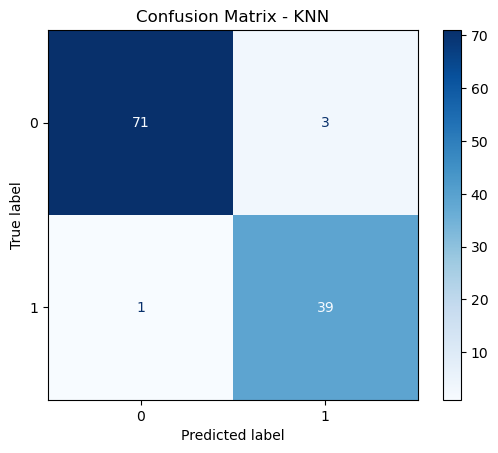

In [14]:
labels = ['Benign', 'Malignant'] if 'B' in y_test.values else None

disp_lr = ConfusionMatrixDisplay(confusion_matrix=np.array(cmknn), display_labels=labels)
disp_lr.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - KNN")
plt.show()

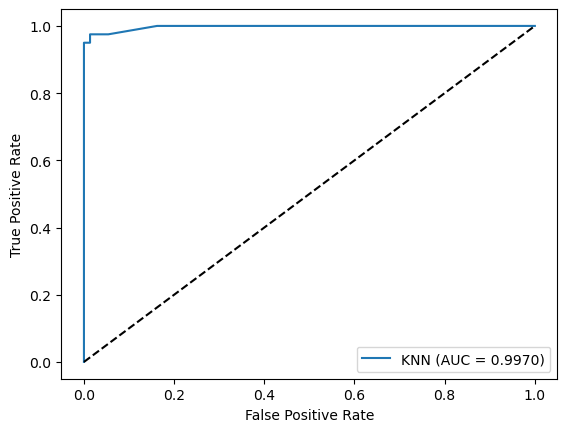

In [147]:
from sklearn.metrics import roc_curve, auc

# get the probability of the positive class
KNN_score = knn.predict_proba(X_test_Knn_scaled)[:, 1]  

fpr, tpr, thresholds = roc_curve(y_test, KNN_score)
roc_auc = auc(fpr, tpr)

# then plot it
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label=f"KNN (AUC = {roc_auc:.4f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Random Forest

In [148]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Step 1: Split the data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize KFold with 5 splits for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a DataFrame to store feature importances from each fold
feature_importances = pd.DataFrame(index=X_train.columns)

# Step 2: K-Fold Cross-validation on the training set
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

    # Standardize only the training data for cross-validation
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_cv), columns=X_train.columns)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val_cv), columns=X_train.columns)

    # Initialize and train the model on the training data
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_scaled, y_train_cv)

    # Get the feature importances from the trained model
    importances = pd.Series(model.feature_importances_, index=X_train.columns)
    feature_importances[f'Fold_{fold+1}'] = importances

# Step 3: Calculate the mean of the feature importances from all folds
feature_importances['Mean'] = feature_importances.mean(axis=1)

# Step 4: Select the top 10 most important features
top_features = feature_importances['Mean'].nlargest(10).index

# Print the top features
print("Top 10 Features Based on Feature Importance:")
print(top_features)


Top 10 Features Based on Feature Importance:
Index(['area_worst', 'concave points_worst', 'concave points_mean',
       'perimeter_worst', 'concavity_mean', 'radius_worst', 'perimeter_mean',
       'radius_mean', 'area_mean', 'concavity_worst'],
      dtype='object')


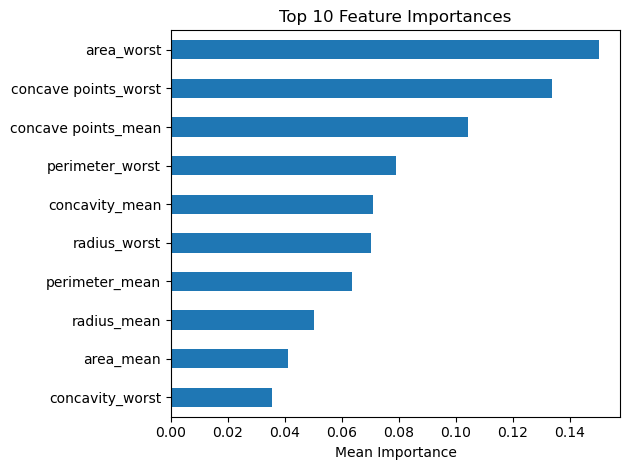

In [149]:
import matplotlib.pyplot as plt

feature_importances.loc[top_features, 'Mean'].sort_values().plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Mean Importance')
plt.tight_layout()
plt.show()


In [150]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4] 
}

X_top = X_train[top_features]
scaler = StandardScaler()
X_top_scaled = pd.DataFrame(scaler.fit_transform(X_top), columns=top_features)

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='accuracy')
grid_search.fit(X_top_scaled, y_train)
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)


Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


Train Accuracy: 0.967032967032967
Test Accuracy: 0.956140350877193


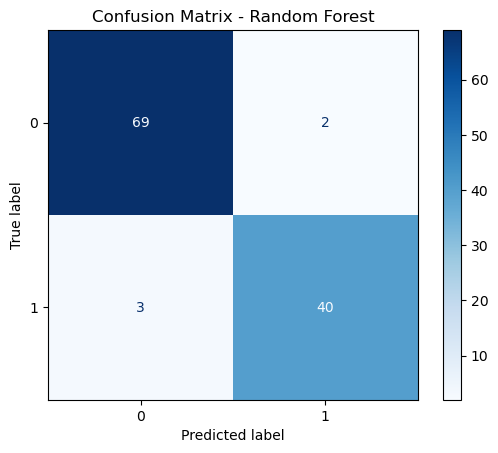

In [151]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Use the top features to subset the training and test sets
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Initialize the RandomForest model with the best hyperparameters
model = RandomForestClassifier(**best_params)

# Standardize 
scaler = StandardScaler()
X_train_RF_scaled = scaler.fit_transform(X_train_top)
X_test_RF_scaled = scaler.transform(X_test_top)

# Train the model on the whole training set with selected features
model.fit(X_train_RF_scaled, y_train)

# Predict on the training set and the test set
y_probs_train = model.predict_proba(X_train_RF_scaled)[:, 1]  
threshold = 0.4
y_train_adjusted = (y_probs_train >= threshold).astype(int)

y_probs_test = model.predict_proba(X_test_RF_scaled)[:, 1]  
threshold = 0.4
y_test_adjusted = (y_probs_test >= threshold).astype(int) 



# Calculate accuracy for both training and test sets
train_accuracy = accuracy_score(y_train, y_train_adjusted)
test_accuracy = accuracy_score(y_test, y_test_adjusted)

# Print accuracy results
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Generate confusion matrix for both train and test sets
train_cm = confusion_matrix(y_train, y_train_adjusted)
test_cm = confusion_matrix(y_test, y_test_adjusted)

disp_rf2 = ConfusionMatrixDisplay(confusion_matrix=test_cm)
disp_rf2.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()

c:\Users\ninac\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


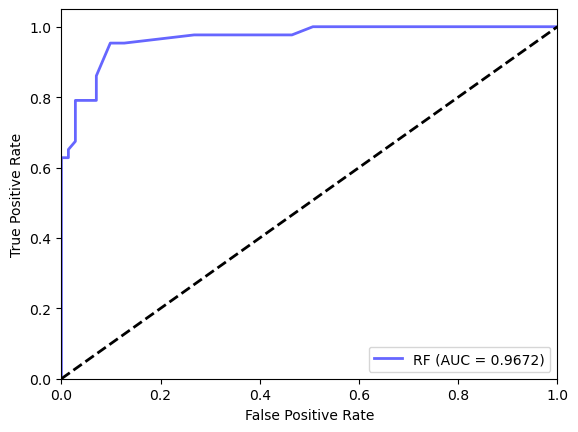

In [152]:

# ROC Curve (for the test set)
# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_top)[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, alpha=0.6, label='RF (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig("roc_curve.png", transparent=True, dpi=300)
plt.show()
